Re-implementation of Image classification CIFAR-10 dataset

In [16]:
#Imports block
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline
import matplotlib.pyplot as plt

from random import shuffle

import gc

In [17]:
#Parameters
validation_set_size = 0.15
batch_size = 20
learning_rate = 0.02
epoch = 10

run_on_gpu = True

In [18]:
# import dataset
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

cifarTrain = datasets.CIFAR10(root='data',download=True,train=True, transform=transform)
cifarTest = datasets.CIFAR10(root='data',download=False,train=True, transform=transform)

Files already downloaded and verified


Nice information about Normalize
https://discuss.pytorch.org/t/how-should-i-convert-tensor-image-range-1-1-to-0-1/26792/2

In [19]:
#Creating Validation and Training Set

index = list(range(len(cifarTrain)))
shuffle(index)
print(index[1:10])

valid_len = int(len(cifarTrain)*validation_set_size)
print(valid_len)

validation_index = index[:valid_len]
train_index = index[valid_len:]
print('Validation Set Size : {} and Training Set Size : {}'.format(len(validation_index),len(train_index)))

[31079, 46430, 30511, 7696, 9857, 6656, 24987, 46017, 47030]
7500
Validation Set Size : 7500 and Training Set Size : 42500


In [20]:
#We can add sampler argument to DataLoader so that it can pick from the indexes as provided to sampler
train_sampler = torch.utils.data.SubsetRandomSampler(train_index)
validation_sampler = torch.utils.data.SubsetRandomSampler(validation_index)

In [21]:
trainloader = torch.utils.data.DataLoader(cifarTrain, sampler= train_sampler, batch_size= batch_size)
validloader = torch.utils.data.DataLoader(cifarTrain, sampler= validation_sampler, batch_size= batch_size)
testloader = torch.utils.data.DataLoader(cifarTest, shuffle= True, batch_size = batch_size)

Till Now we have loaded the data, applied transforms on it and then created train, validation and test sets

Next, the tasks we have to do are -
1. Define Neural Network class : SImilar to VGG 16
    2 conv + pool
    3 conv + pool
    FC 1
    FC 2
    Log Softmax
    
2. Define loss function NNLoss
3. Define optimizer
4. Train the model
5. Find Validation error on the current model using different hyperparameters
6. Find Test set error on the final model

## Question : How should we select the best Model and other parameters of the model
My choices were to use existing architecture or randomly select any architecture

In [22]:
class ConvNetModel(nn.Module):
    def __init__(self, input_depth, hidden_depth = 4, kernel_size = 3, pad = 1, stride = 1):
        
        super().__init__()
        
        #3 -> 16 
        self.conv1_1 = nn.Conv2d(input_depth,hidden_depth*4,kernel_size,padding=pad,stride=stride)
        #16 -> 32
        self.conv1_2 = nn.Conv2d(hidden_depth*4,hidden_depth*8,kernel_size,padding=pad,stride=stride)
        
        self.maxpool = nn.MaxPool2d(2,2)
        
        #32 -> 64
        self.conv2_1 = nn.Conv2d(hidden_depth*8, hidden_depth*16,kernel_size,padding=pad,stride=stride)
        #64 -> 128
        self.conv2_2 = nn.Conv2d(hidden_depth*16, hidden_depth*32,kernel_size,padding=pad,stride=stride)
        #128 -> 256
        self.conv2_3 = nn.Conv2d(hidden_depth*32, hidden_depth*64,kernel_size,padding=pad,stride=stride)
        
        self.dropout = nn.Dropout(p=0.2)
        
        #self.linear_1 = nn.Linear(16384,256)
        self.linear_1 = nn.Linear(8192,256)
        self.linear_2 = nn.Linear(256,10)
        
    def forward(self,x):
        
        x = F.relu(self.conv1_1(x),0.2)
        x = F.relu(self.conv1_2(x),0.2)
        
        x = self.maxpool(x)
        
        x = F.relu(self.conv2_1(x),0.2)
        x = F.relu(self.conv2_2(x),0.2)
        #x = F.relu(self.conv2_3(x),0.2)
        
        x = self.maxpool(x)
        
        #x = x.view(-1,16384)
        x = x.view(-1,8192)
        x = self.dropout(x)
        x = F.relu(self.linear_1(x),0.2)
        x = self.dropout(x)
        x = F.log_softmax(self.linear_2(x),dim=1)
        
        return x
        

In [23]:
model = None
gc.collect()
model = ConvNetModel(3)

if run_on_gpu == True:
    model.cuda()

model

ConvNetModel(
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.2)
  (linear_1): Linear(in_features=8192, out_features=256, bias=True)
  (linear_2): Linear(in_features=256, out_features=10, bias=True)
)

In [24]:
#Loss Function and Optimizer
optimizer = optim.SGD(model.parameters(),lr = learning_rate)
loss_func = nn.NLLLoss()

In [25]:
def train_model(epoch = 50, run_on_gpu = False):
    train_loss = []
    validation_loss = []
    
    for i in range(epoch):
        calc_loss = 0
        model.train()
        for images, labels in trainloader:
            if run_on_gpu == True:
                images = images.cuda()
                labels = labels.cuda()
            
            optimizer.zero_grad()
            
            pred = model(images)
            
            loss = loss_func(pred,labels)
            loss.backward()
            optimizer.step()
            
            calc_loss += loss
            
            if run_on_gpu == True:
                del images, labels, pred, loss
                gc.collect()
        
        valid_loss = 0
        model.eval()
        
        for images_valid, labels_valid in validloader:
            
            with torch.no_grad():
                if run_on_gpu == True:
                    images_valid = images_valid.cuda()
                    labels_valid = labels_valid.cuda()

                pred_valid = model(images_valid)
                loss_valid = loss_func(pred_valid,labels_valid)

                valid_loss += loss_valid

                if run_on_gpu == True:
                    del images_valid, labels_valid, pred_valid, loss_valid
                    gc.collect()

        validation_loss.append(valid_loss/len(validloader))
        train_loss.append(calc_loss/len(trainloader))
        print('Training loss after {} epoch is {} and Validation loss is {}'.format(i+1,calc_loss/len(trainloader), valid_loss/len(validloader)))
    
    return (train_loss,validation_loss)

In [12]:
#torch.cuda.empty_cache()
train_loss, valid_loss = train_model(15,run_on_gpu)

Training loss after 1 epoch is 1.850961685180664 and Validation loss is 1.7243943214416504
Training loss after 2 epoch is 1.3948643207550049 and Validation loss is 1.203596591949463
Training loss after 3 epoch is 1.1780731678009033 and Validation loss is 1.0443751811981201
Training loss after 4 epoch is 0.9945945739746094 and Validation loss is 0.9313376545906067
Training loss after 5 epoch is 0.8442202210426331 and Validation loss is 0.8545878529548645
Training loss after 6 epoch is 0.7159696221351624 and Validation loss is 0.7794846296310425
Training loss after 7 epoch is 0.6032129526138306 and Validation loss is 0.7990761399269104
Training loss after 8 epoch is 0.4978007376194 and Validation loss is 0.7913150787353516
Training loss after 9 epoch is 0.4054865539073944 and Validation loss is 0.7911463975906372
Training loss after 10 epoch is 0.3259758949279785 and Validation loss is 0.8071067333221436
Training loss after 11 epoch is 0.2667950391769409 and Validation loss is 0.88531583

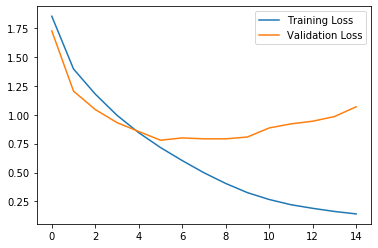

In [13]:
plt.plot(train_loss, label = 'Training Loss')
plt.plot(valid_loss, label = 'Validation Loss')
plt.legend()
plt.show()

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [14]:
def get_test_accuracy():
    with torch.no_grad():
        correct = 0
        total = 0
        for image_test, label_test in testloader:
            if run_on_gpu == True:
                image_test = image_test.cuda()
                label_test = label_test.cuda()
            
            total += len(label_test)
            pred_test = model(image_test)
            _, predictions = torch.max(pred_test,1)
            correct += (predictions == label_test).sum().item()
    return (correct*100.0)/total


In [29]:
get_test_accuracy()
#95.5% accuracy on test set when trained for 15 epochs
#69.42% accuracy when trained for 4 epochs

69.422

In [27]:
#torch.cuda.empty_cache()
train_loss, valid_loss = train_model(4,run_on_gpu)

Training loss after 1 epoch is 1.8770772218704224 and Validation loss is 1.5516940355300903
Training loss after 2 epoch is 1.4012296199798584 and Validation loss is 1.3141329288482666
Training loss after 3 epoch is 1.1867622137069702 and Validation loss is 1.1289939880371094
Training loss after 4 epoch is 1.0149348974227905 and Validation loss is 0.9885300993919373


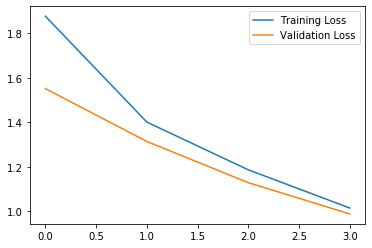

In [28]:
plt.plot(train_loss, label = 'Training Loss')
plt.plot(valid_loss, label = 'Validation Loss')
plt.legend()
plt.show()

#Few Things to think about
1. 